[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)

# Dynamic breakpoints 

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like `Approval`

We also showed how to edit graph state, and introduce human feedback. 

## Goals

Breakpoints are set by the developer on a specific node during graph compilation. 

But, sometimes it is helpful to allow the graph **dynamically interrupt** itself!

This is an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

(1) you can do it conditionally (from inside a node based on developer-defined logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `NodeInterrupt`).

Let's create a graph where a `NodeInterrupt` is thrown based upon length of the input.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

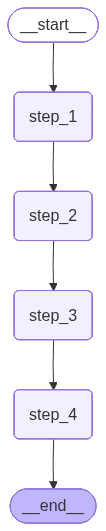

In [3]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    # Add interrupt if input contains certain keywords
    if state['input'].lower() in ['stop', 'exit', 'quit']:
        raise NodeInterrupt(f"Execution halted: keyword '{state['input']}' detected")
    
    print("---Step 3---")
    return state

def step_4(state: State) -> State:
    print("---Step 4---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_node("step_4", step_4)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", "step_4")
builder.add_edge("step_4", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with an input that's longer than 5 characters. 

In [4]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),)}


C:\Users\riyaa\AppData\Local\Temp\ipykernel_31612\259514893.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


If we inspect the graph state at this point, we the node set to execute next (`step_2`).


In [5]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that the `Interrupt` is logged to state.

In [6]:
print(state.tasks)

(PregelTask(id='1fd0c4fd-e0e7-49dc-9289-e2f1aa6addb0', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),), state=None, result=None),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

In [7]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),)}


C:\Users\riyaa\AppData\Local\Temp\ipykernel_31612\259514893.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [8]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Now, we can update state.

In [9]:
graph.update_state(
    thread_config,
    {"input": "exit"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3655-f875-6fe6-8002-8dae8649c408'}}

In [10]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'exit'}
---Step 2---
{'input': 'exit'}
{'__interrupt__': (Interrupt(value="Execution halted: keyword 'exit' detected", id='placeholder-id'),)}


C:\Users\riyaa\AppData\Local\Temp\ipykernel_31612\259514893.py:26: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Execution halted: keyword '{state['input']}' detected")


In [12]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3657-cc4b-6204-8004-8e15ad70874d'}}

In [13]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 3---
{'input': 'hi'}
---Step 4---
{'input': 'hi'}


### Usage with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

In [1]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

We connect to it via the SDK.

In [14]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [16]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic-breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a2707-1835-76b0-8887-ff05201a4180', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'__interrupt__': [{'value': 'Received input that is longer than 5 characters: hello world', 'id': 'placeholder-id'}]}





In [17]:
current_state = await client.threads.get_state(thread['thread_id'])

In [18]:
current_state['next']

['step_2']

In [19]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'checkpoint': {'thread_id': '26634603-3e7f-4f04-9110-5726b3680a94',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3669-e148-623f-8002-a20bb2f7953a'},
 'configurable': {'thread_id': '26634603-3e7f-4f04-9110-5726b3680a94',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3669-e148-623f-8002-a20bb2f7953a'},
 'checkpoint_id': '1f0b3669-e148-623f-8002-a20bb2f7953a'}

In [21]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic-breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a2707-601f-76e8-9528-38fa5883eddd', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [22]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': [],
 'tasks': [],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '9db5ce93-9134-49d7-a792-1d86e370c568',
  'graph_id': 'dynamic-breakpoints',
  'assistant_id': 'f7b9dbf1-28d3-54d1-8591-eedb44ca5a90',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '1.0.1',
  'langgraph_api_version': '0.4.46',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '019a2707-601f-76e8-9528-38fa5883eddd',
  'thread_id': '26634603-3e7f-4f04-9110-5726b3680a94',
  'source': 'loop',
  'step': 5,
  'parents': {}},
 'created_at': '2025-10-27T18:56:27.170800+00:00',
 'checkpoint': {'checkpoint_id': '1f0b366a-438c-6fa0-8005-0cee0d90f427',
  'thread_id': '26634603-3e7f-4f04-9110-5726b3680a94',
  'checkpoint_ns': ''},
 'parent_checkpoint': {'checkpoint_id': '1f0b366a-4386-6c34-800